<a href="https://colab.research.google.com/github/Shisiajoy/ANOMALY-DETECTION-FOR-CANCER-/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS

In [81]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, class_weight
from sklearn.metrics import roc_auc_score

# Other
import os
import shutil
import cv2  # For image processing
import random
from google.colab import userdata





In [2]:
# Access the secret key
secret_value = userdata.get('shisiajoy')

In [3]:
pip install pillow


In [4]:
# Install Kaggle API if not already installed
!pip install kaggle


In [5]:
!kaggle datasets download -d gauravduttakiit/rsna-screening-mammography-breast-cancer-detection



Dataset URL: https://www.kaggle.com/datasets/gauravduttakiit/rsna-screening-mammography-breast-cancer-detection
License(s): CC0-1.0
 99% 993M/0.98G [00:13<00:00, 93.1MB/s]
100% 0.98G/0.98G [00:13<00:00, 80.1MB/s]


In [6]:
!unzip rsna-screening-mammography-breast-cancer-detection.zip -d /content/rsna_mammography_dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/rsna_mammography_dataset/output/train/63617_1917877119.png  
  inflating: /content/rsna_mammography_dataset/output/train/63617_887426674.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1186739164.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_1657034655.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_335778602.png  
  inflating: /content/rsna_mammography_dataset/output/train/63623_625719002.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_1154699412.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_549972940.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_599167493.png  
  inflating: /content/rsna_mammography_dataset/output/train/63626_939566995.png  
  inflating: /content/rsna_mammography_dataset/output/train/63627_1214214469.png  
  inflating: /content/rsna_mammography_dat

In [7]:
!ls /content/rsna_mammography_dataset


output	test.csv  train.csv


In [8]:
train_df = pd.read_csv("/content/rsna_mammography_dataset/train.csv")
test_df = pd.read_csv("/content/rsna_mammography_dataset/test.csv")

In [9]:
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10006,462822612,L,CC,61.0,0,29,10006_L,0
1,2,10006,1459541791,L,MLO,61.0,0,29,10006_L,0
2,2,10006,1864590858,R,MLO,61.0,0,29,10006_R,0
3,2,10006,1874946579,R,CC,61.0,0,29,10006_R,0
4,2,10011,220375232,L,CC,55.0,0,21,10011_L,0


In [10]:
test_df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


##EDA

- Age distribution

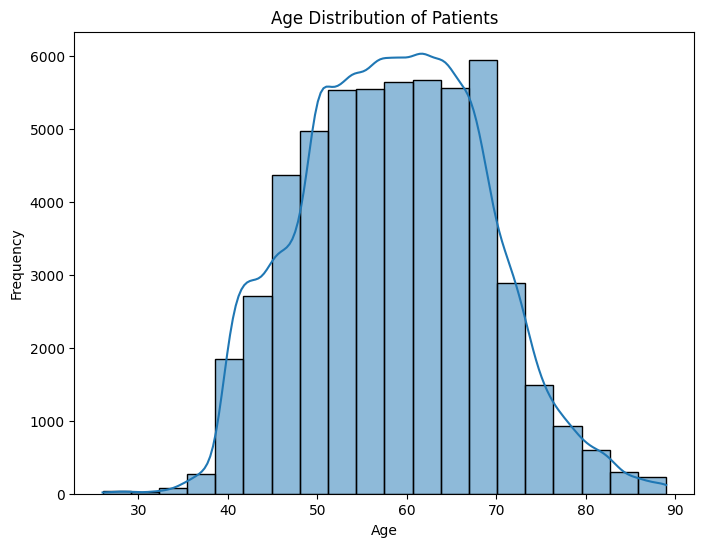

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(train_df['age'], bins=20, kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


- Age vs Cancer

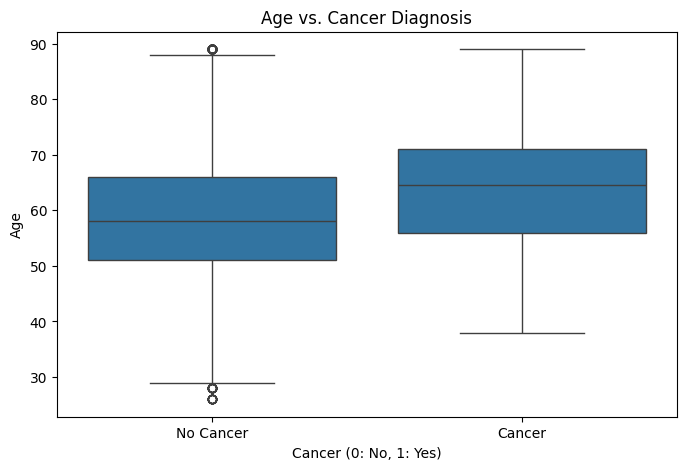

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='cancer', y='age', data=train_df)
plt.title('Age vs. Cancer Diagnosis')
plt.xlabel('Cancer (0: No, 1: Yes)')
plt.ylabel('Age')
plt.xticks([0, 1], ['No Cancer', 'Cancer'])
plt.show()


- Cancer diagnosis by Laterality and view

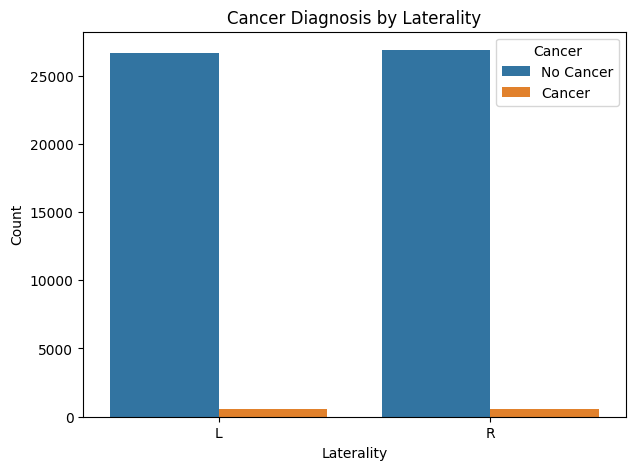

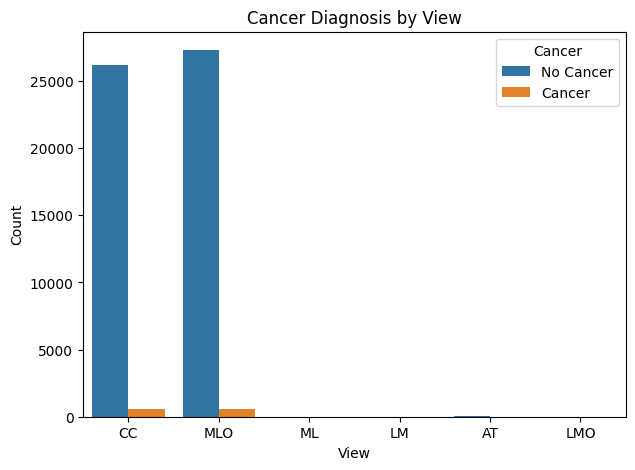

In [13]:
plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, x='laterality', hue='cancer')
plt.title('Cancer Diagnosis by Laterality')
plt.xlabel('Laterality')
plt.ylabel('Count')
plt.legend(title='Cancer', labels=['No Cancer', 'Cancer'])
plt.show()

plt.figure(figsize=(7, 5))
sns.countplot(data=train_df, x='view', hue='cancer')
plt.title('Cancer Diagnosis by View')
plt.xlabel('View')
plt.ylabel('Count')
plt.legend(title='Cancer', labels=['No Cancer', 'Cancer'])
plt.show()


- Cancer class distribution

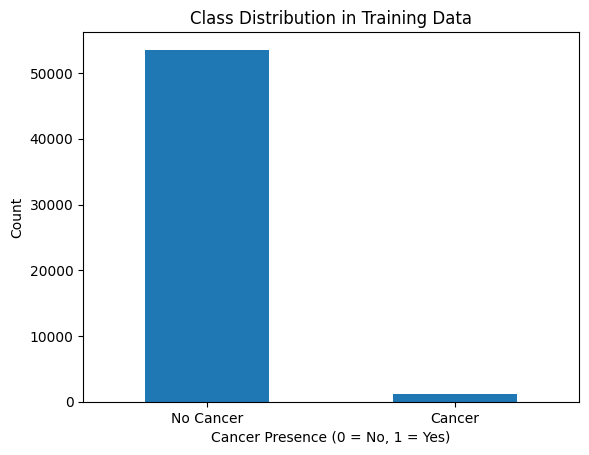

In [14]:
# Plot class distribution
train_df['cancer'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Data')
plt.xlabel('Cancer Presence (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No Cancer', 'Cancer'], rotation=0)
plt.show()

## SETTING UP DIRECTORIES

In [15]:
# Define paths
base_path = '/content/rsna_mammography_dataset/output/train'
cancer_path = os.path.join(base_path, 'cancer')
no_cancer_path = os.path.join(base_path, 'no_cancer')


In [16]:
# Create the cancer and no_cancer directories
os.makedirs(cancer_path, exist_ok=True)
os.makedirs(no_cancer_path, exist_ok=True)

# Function to move images to respective directories
def organize_images(row):
    patient_id = row['patient_id']
    image_id = row['image_id']
    cancer_label = row['cancer']  # Assuming 1 indicates cancer, 0 indicates no cancer

    image_filename = f"{patient_id}_{image_id}.png"
    image_path = os.path.join(base_path, image_filename)

    # Check if the image exists
    if os.path.exists(image_path):
        if cancer_label == 1:
            shutil.move(image_path, os.path.join(cancer_path, image_filename))
        else:
            shutil.move(image_path, os.path.join(no_cancer_path, image_filename))
    else:
        print(f"Image {image_filename} not found in {base_path}.")

# Apply the function to organize images
train_df.apply(organize_images, axis=1)
print("Images have been organized into 'cancer' and 'no_cancer' folders.")


Images have been organized into 'cancer' and 'no_cancer' folders.


In [17]:
# Function to load a subset of images from the 'no_cancer' folder
def load_images_from_folder(folder, img_size=(128, 128), sample_size=None):
    images = []
    filenames = os.listdir(folder)

    # If a sample size is provided, randomly select images
    if sample_size:
        filenames = random.sample(filenames, sample_size)

    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
    return np.array(images)

# Load only a subset of no cancer images
subset_size = 10050
no_cancer_images = load_images_from_folder(no_cancer_path, sample_size=subset_size)


In [18]:
# Normalize and reshape the images
no_cancer_images = no_cancer_images.astype('float32') / 255.0
no_cancer_images = np.expand_dims(no_cancer_images, axis=-1)


## TRAIN VALIDATION SPLIT

In [19]:
# Split data into training and validation sets
train_images, val_images = train_test_split(no_cancer_images, test_size=0.2, random_state=42)

## MODEL CREATION

In [20]:
# Define the autoencoder model
def build_autoencoder(input_shape):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Latent space
    latent = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(latent)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoder_output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Create the autoencoder model
    autoencoder = models.Model(encoder_input, decoder_output)
    return autoencoder

# Set input shape for the model (image size 128x128, with 1 channel for grayscale)
input_shape = (128, 128, 1)
autoencoder = build_autoencoder(input_shape)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')




## MODEL TRAINING

In [ ]:
# Train the autoencoder
history = autoencoder.fit(train_images, train_images,
                          epochs=15,
                          batch_size=32,
                          validation_data=(val_images, val_images))

Epoch 1/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 790s 3s/step - loss: 0.3125 - val_loss: 0.2218
Epoch 2/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 815s 3s/step - loss: 0.2219 - val_loss: 0.2200
Epoch 3/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 802s 3s/step - loss: 0.2195 - val_loss: 0.2191
Epoch 4/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 854s 3s/step - loss: 0.2199 - val_loss: 0.2187
Epoch 5/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 801s 3s/step - loss: 0.2198 - val_loss: 0.2189
Epoch 6/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 796s 3s/step - loss: 0.2188 - val_loss: 0.2184
Epoch 7/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 789s 3s/step - loss: 0.2173 - val_loss: 0.2221
Epoch 8/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 792s 3s/step - loss: 0.2204 - val_loss: 0.2186
Epoch 9/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 778s 3s/step - loss: 0.2192 - val_loss: 0.2177
Epoch 10/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 788s 3s/step - loss: 0.2201 - val_loss: 0.2178
Epoch 11/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 803s 3s/step - loss: 0.2179 - val_loss: 0.2181
Epoch 12/15
252/252 ━━━━━━━━━━━━━━━━━━━━ 

In [24]:
# Save the autoencoder in Keras format
autoencoder.save('autoencoder_model.keras')


In [26]:
from google.colab import files
files.download('autoencoder_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TESTING ON CANCER DATASET

In [27]:
from keras.models import load_model

# Load the saved autoencoder
autoencoder = load_model('autoencoder_model.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [71]:
# Define image dimensions and batch size
image_size = (128, 128)  # Or the size you trained your model on
batch_size = 16

# Create ImageDataGenerator for cancer images
datagen = ImageDataGenerator(rescale=1./255)

# Load cancer images from directory
cancer_data = datagen.flow_from_directory(
    '/content/rsna_mammography_dataset/output/train',
    target_size=image_size,
    color_mode='grayscale',  # Assuming grayscale images
    class_mode=None,
    batch_size=batch_size,
    shuffle=False,
    classes=['cancer']
)

# Convert to numpy array
cancer_images = np.concatenate([next(cancer_data)[0] for i in range(len(cancer_data))])



Found 1158 images belonging to 1 classes.


## Reconstruct images using the Autoencoder

In [75]:
# Predicting the reconstructed images
reconstructed_images = autoencoder.predict(cancer_images)


292/292 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


## Reconstuction error

In [77]:
# Convert reconstructed images to grayscale by averaging across the color channels (assuming RGB)
reconstructed_images_gray = np.mean(reconstructed_images, axis=2)  # Average across the channel axis

# Now calculate the reconstruction errors
reconstruction_errors = np.mean(np.square(cancer_images - reconstructed_images_gray), axis=(1, 2))


In [78]:
# Print the first few errors to check
print(reconstruction_errors[:10])

[0.00808557 0.00805952 0.00537476 0.00629534 0.00313173 0.00028536
 0.00072613 0.00076628 0.00093704 0.00089377]


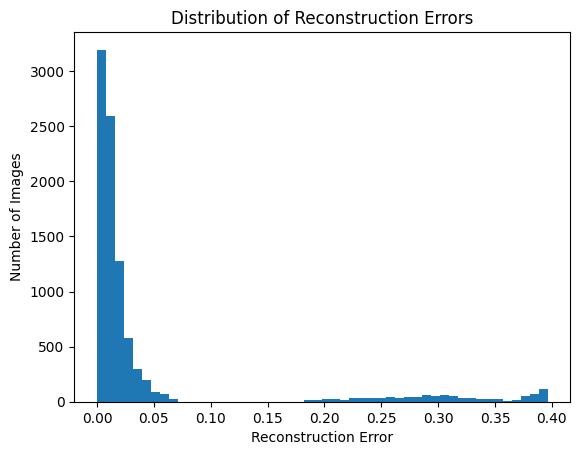

In [79]:
# Plot histogram of reconstruction errors
plt.hist(reconstruction_errors, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Images")
plt.title("Distribution of Reconstruction Errors")
plt.show()


In [119]:
# Set a threshold (you can choose based on visualization or other criteria)
threshold = np.percentile(reconstruction_errors, 90)  # Example: Top 5% most erroneous reconstructions

# Identify images with reconstruction errors above the threshold
anomalies = reconstruction_errors > threshold
print(f"Number of detected anomalies: {np.sum(anomalies)}")


Number of detected anomalies: 935


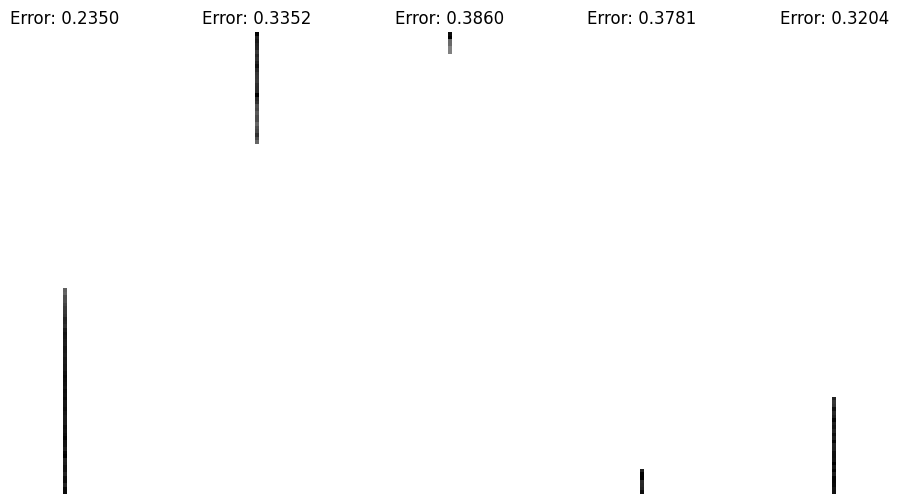

In [123]:
import matplotlib.pyplot as plt

# Select indices of detected anomalies
anomaly_indices = np.where(anomalies)[0]

# Visualize some anomalies
num_samples = 5  # Number of anomaly samples to visualize
sample_indices = np.random.choice(anomaly_indices, size=num_samples, replace=False)

plt.figure(figsize=(12, 6))
for i, index in enumerate(sample_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(cancer_images[index], cmap='gray')  # Assuming images are in grayscale
    plt.title(f'Error: {reconstruction_errors[index]:.4f}')
    plt.axis('off')
plt.show()


In [124]:
# Assuming `reconstruction_errors` is a NumPy array containing your reconstruction errors

# Calculate the  percentile threshold
percentile_value = 90
threshold = np.percentile(reconstruction_errors, percentile_value)

#  Print the threshold
print(f"Threshold set at the {percentile_value}th percentile: {threshold}")

# Identify anomalies based on the threshold
anomalies = reconstruction_errors > threshold

#  Count the number of detected anomalies
number_of_anomalies = np.sum(anomalies)
print(f"Number of detected anomalies: {number_of_anomalies}")


Threshold set at the 90th percentile: 0.22051914036273979
Number of detected anomalies: 935


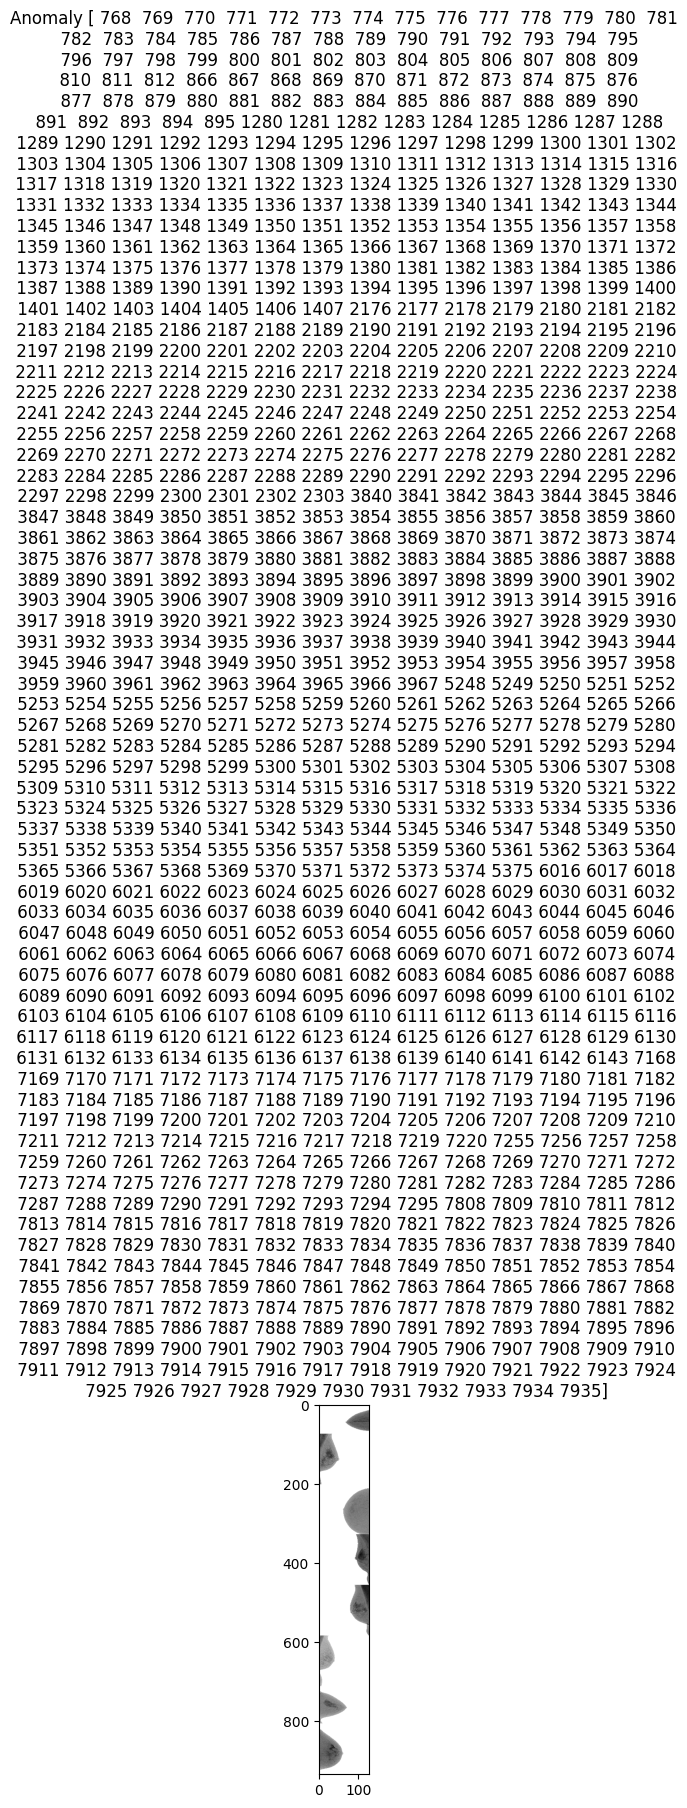

In [120]:
# Get indices of the detected anomalies
anomaly_indices = np.where(anomalies == 1)

# Visualize or analyze a subset of the detected anomalies
for idx in anomaly_indices[:5]:  # Just showing a few as an example
    plt.imshow(cancer_images[idx].squeeze(), cmap='gray')
    plt.title(f"Anomaly {idx}")
    plt.show()


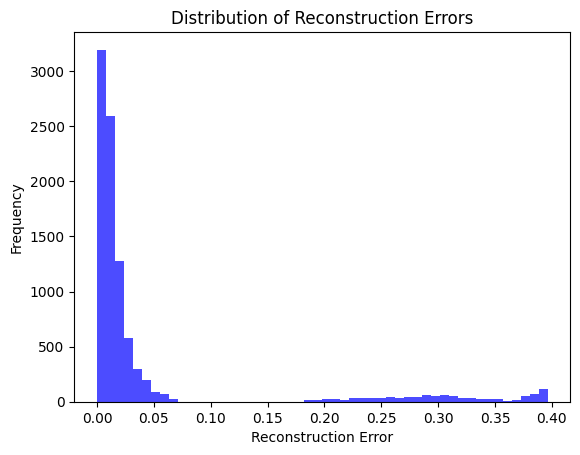

In [121]:
# Plot a histogram of reconstruction errors
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


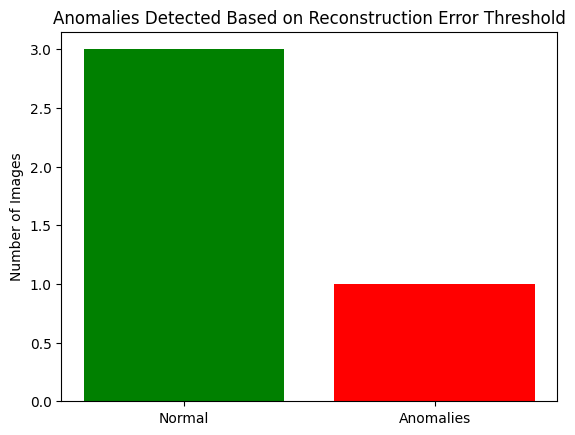

In [159]:
# Choose a threshold for anomalies
threshold = 0.001 # Experiment with a reasonable threshold

# Mark anomalies based on the threshold
anomalies = reconstruction_errors > threshold

# Plot the number of anomalies detected
plt.bar(['Normal', 'Anomalies'], [np.sum(anomalies == 0), np.sum(anomalies == 1)], color=['green', 'red'])
plt.title("Anomalies Detected Based on Reconstruction Error Threshold")
plt.ylabel("Number of Images")
plt.show()


In [112]:
# Compute statistics for reconstruction errors
normal_reconstruction_errors = reconstruction_errors[~anomalies]
anomaly_reconstruction_errors = reconstruction_errors[anomalies]

print("Normal Reconstruction Errors Statistics:")
print(f"Mean: {np.mean(normal_reconstruction_errors)}, Median: {np.median(normal_reconstruction_errors)}")
print(f"Std Dev: {np.std(normal_reconstruction_errors)}, Variance: {np.var(normal_reconstruction_errors)}")

print("\nAnomaly Reconstruction Errors Statistics:")
print(f"Mean: {np.mean(anomaly_reconstruction_errors)}, Median: {np.median(anomaly_reconstruction_errors)}")
print(f"Std Dev: {np.std(anomaly_reconstruction_errors)}, Variance: {np.var(anomaly_reconstruction_errors)}")


Normal Reconstruction Errors Statistics:
Mean: 0.00011377836926840246, Median: 1.545161103422288e-05
Std Dev: 0.00024296158517245203, Variance: 5.903033439835781e-08

Anomaly Reconstruction Errors Statistics:
Mean: 0.050152502954006195, Median: 0.01363079808652401
Std Dev: 0.09789510071277618, Variance: 0.009583450853824615


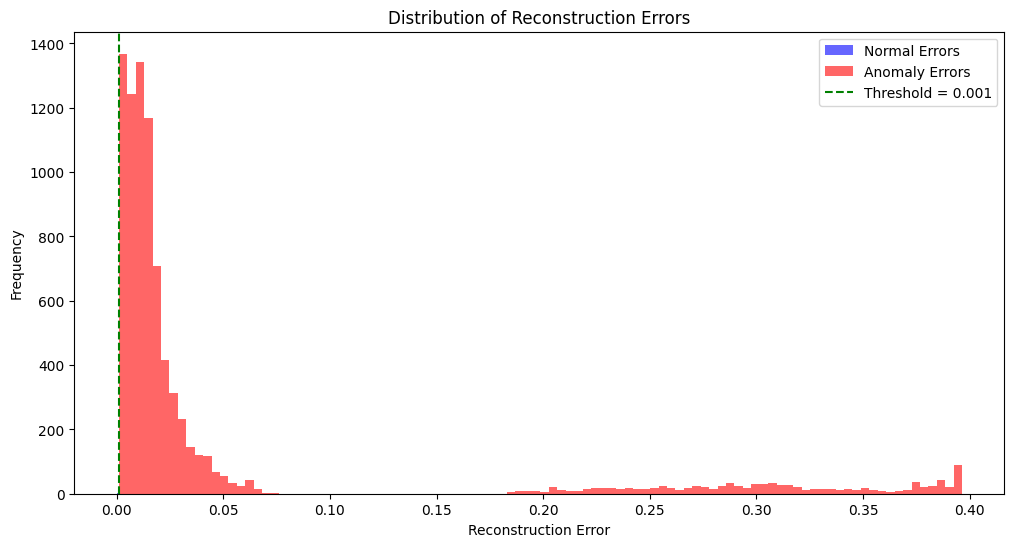

In [117]:
plt.figure(figsize=(12, 6))
plt.hist(normal_reconstruction_errors, bins=100, alpha=0.6, color='blue', label='Normal Errors')
plt.hist(anomaly_reconstruction_errors, bins=100, alpha=0.6, color='red', label='Anomaly Errors')
plt.axvline(x=0.001, color='green', linestyle='--', label='Threshold = 0.001')
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## TESTING ON TEST DATA

In [129]:
import os
import numpy as np
import cv2  # OpenCV for image processing
from keras.models import load_model

#  Define a function to load and preprocess images
def load_and_preprocess_images(image_dir, target_size=(224, 224)):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, target_size)  # Resize to match input size of your autoencoder
            image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)

    # Convert list to NumPy array and add batch dimension
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # Add channel dimension if needed (e.g., for grayscale)
    return images

#  Load test images from the specified path
test_image_path = '/content/rsna_mammography_dataset/output/test'
test_images = load_and_preprocess_images(test_image_path)



In [134]:
def load_and_preprocess_images(image_dir, target_size=(128, 128)):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png') or filename.endswith('.jpg'):  # Adjust for your image formats
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale if needed
            image = cv2.resize(image, target_size)  # Resize to match input size of your autoencoder
            image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)

    # Convert list to NumPy array and add batch dimension
    images = np.array(images)

    # Ensure the shape matches the expected input of the autoencoder
    if len(images.shape) == 3:  # If images shape is (num_images, height, width)
        images = np.expand_dims(images, axis=-1)  # Add channel dimension (e.g., for grayscale)

    return images


In [135]:
# Load test images
test_images = load_and_preprocess_images(test_image_path)

# Print shapes
print(f"Shape of test images: {test_images.shape}")
print(f"Expected input shape of autoencoder: {autoencoder.input_shape}")


Shape of test images: (4, 128, 128, 1)
Expected input shape of autoencoder: (None, 128, 128, 1)


In [138]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


In [139]:
print(type(test_images))  # Should be a numpy array
print(test_images.dtype)  # Ensure the dtype is compatible (e.g., float32)


<class 'numpy.ndarray'>
float32


In [140]:
test_images = test_images.reshape((test_images.shape[0], 128, 128, 1))


In [141]:
reconstructed_test_images = autoencoder.predict(test_images)

# Optional: Check the shape of the reconstructed images
print(f"Shape of reconstructed images: {reconstructed_test_images.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Shape of reconstructed images: (4, 128, 128, 1)


In [142]:

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(test_images - reconstructed_test_images), axis=(1, 2, 3))

In [147]:
# Set a threshold (e.g., 90th percentile)
threshold = np.percentile(reconstruction_errors, 90)
print(f"Threshold for anomalies: {threshold}")

# Identify anomalies
anomalies = reconstruction_errors > threshold
print(f"Number of detected anomalies: {np.sum(anomalies)}")

Threshold for anomalies: 0.0011713046347722412
Number of detected anomalies: 1


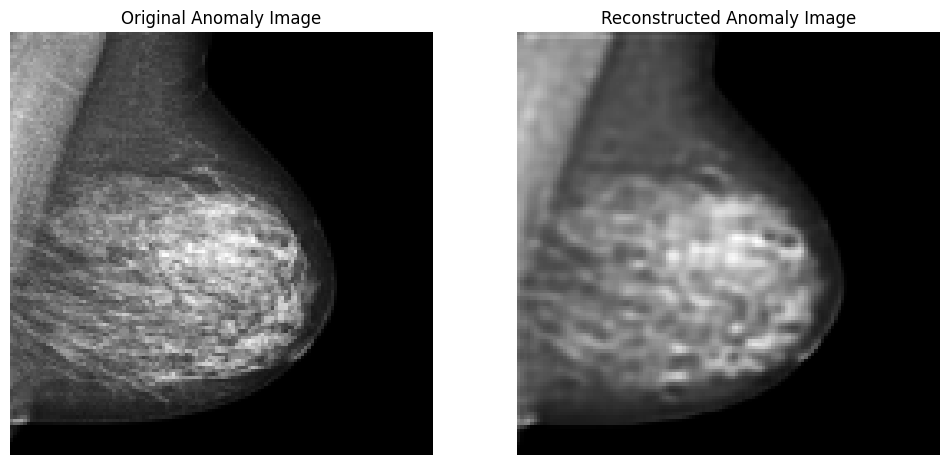

In [148]:
# Assuming you have a way to retrieve the original images
anomaly_index = np.where(anomalies)[0][0]  # Get the index of the detected anomaly
original_anomaly_image = test_images[anomaly_index]
reconstructed_anomaly_image = reconstructed_test_images[anomaly_index]

# Display the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Anomaly Image')
plt.imshow(original_anomaly_image.squeeze(), cmap='gray')  # Adjust according to your image channel
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Anomaly Image')
plt.imshow(reconstructed_anomaly_image.squeeze(), cmap='gray')
plt.axis('off')

plt.show()


In [160]:
import json

# Save the threshold value to a JSON file
threshold_value = 0.0011713046347722412
with open('threshold.json', 'w') as json_file:
    json.dump({'threshold': threshold_value}, json_file)
